In [3]:
#--------------------------------------------------------------------------------
# Module 1: Loading pickled big boi data for GAN model
#--------------------------------------------------------------------------------
import os
import pandas as pd

# Ensure the directory "Processed data" exists before attempting to load the file
if os.path.exists("Processed data/data_encoded.csv"):
    data_encoded = pd.read_csv("Processed data/data_encoded.csv")
else:
    print("The CSV file does not exist in the specified directory.")


#import pickle
#import os

# Ensure the directory "Processed data" exists before attempting to load the file
#if os.path.exists("Processed data/data_encoded.csv"):
 #   with open("Processed data/data_encoded.csv", "rb") as file:
  #      data_encoded = file
   #     print(data_encoded.columns)
#else:
 #   print("The pickled file does not exist in the specified directory.")


In [4]:
#--------------------------------------------------------------------------------
# Module 2: Define the Generator model
#--------------------------------------------------------------------------------

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout, GaussianNoise

# Define the size of the random noise input (latent dimension)
latent_dim = 100
num_features = data_encoded.shape[1]

def build_generator():
    model = Sequential()

    model.add(Dense(64*8, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64*16))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64*32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))


    model.add(Dense(64*64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))


    model.add(Dense(64*128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(num_features, activation='sigmoid'))

    return model

generator = build_generator()
generator.summary()

2023-11-30 14:33:37.501847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 gaussian_noise (GaussianNo  (None, 512)               0         
 ise)                                                            
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              5

In [5]:
#--------------------------------------------------------------------------------
# Module 3: Define the Discriminator model
#--------------------------------------------------------------------------------

from tensorflow.keras.regularizers import l2

def build_discriminator():
    model = Sequential()

    model.add(Dense(64*128, input_dim=num_features, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64*64, input_dim=num_features, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))


    model.add(Dense(64*32, input_dim=num_features, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64*16, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64*8, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8192)              2891776   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 batch_normalization_5 (Bat  (None, 8192)              32768     
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 8192)              0         
                                                                 
 dense_7 (Dense)             (None, 4096)              33558528  
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4096)              0         
                                                      

In [6]:
#--------------------------------------------------------------------------------
# Module 4: Compile the Discriminator model
#   1. Using legacy Keras optimizer as i have an m2 chip macbook
#--------------------------------------------------------------------------------

from tensorflow.keras.optimizers.legacy import Adam

# Compile the Discriminator using the legacy optimizer ALTERNATIVES: 'mean_squared_error'
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])



In [7]:
#--------------------------------------------------------------------------------
# Module 5: Combined GAN Structure
#   OBS! Discriminator trainable=False as we dont wants to change its weights 
#   while during this initial generator training process.
#--------------------------------------------------------------------------------

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Ensure that the discriminator is not trainable when combined with the generator
discriminator.trainable = False

# Define the GAN's input (noise) and output (discriminator's probability for the generated sample)
gan_input = Input(shape=(latent_dim,))
generated_sample = generator(gan_input)
gan_output = discriminator(generated_sample)

# Define the combined GAN model
gan = Model(gan_input, gan_output)

# Compile the GAN using the same loss and optimizer as the discriminator
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))

gan.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 352)               47578976  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 47527937  
                                                                 
Total params: 95106913 (362.80 MB)
Trainable params: 47547232 (181.38 MB)
Non-trainable params: 47559681 (181.43 MB)
_________________________________________________________________


In [8]:
#--------------------------------------------------------------------------------
# Module 6: Training the GAN
#--------------------------------------------------------------------------------

import numpy as np

# Define training hyperparameters
epochs = 100 #500
batch_size = 256 #120
half_batch = batch_size // 2

# Lists to hold loss and accuracy values for plotting after training
d_losses = []
d_accuracies = []
g_losses = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Select a random half batch of real samples
    idx = np.random.randint(0, data_encoded.shape[0], half_batch)
    real_samples = data_encoded.iloc[idx].values.astype('float32')

    # Generate half batch of fake samples
    noise = np.random.normal(0, 1, (half_batch, latent_dim)).astype('float32')
    fake_samples = generator.predict(noise).astype('float32')

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((half_batch, 1)).astype('float32'))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((half_batch, 1)).astype('float32'))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype('float32')
    valid_y = np.ones((batch_size, 1)).astype('float32')
    
    # Train the generator
    g_loss = gan.train_on_batch(noise, valid_y)

    # Save losses and accuracy for plotting
    d_losses.append(d_loss[0])
    d_accuracies.append(100 * d_loss[1])
    g_losses.append(g_loss)

    # Print the progress
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

print("Training finished.")


4/4 [==============================] - 0s 27ms/step
0/100 [D loss: 109.92004776000977 | D accuracy: 53.515625] [G loss: 109.17156982421875]
4/4 [==============================] - 0s 25ms/step
1/100 [D loss: 109.21697616577148 | D accuracy: 51.953125] [G loss: 108.48316192626953]
4/4 [==============================] - 0s 26ms/step
2/100 [D loss: 108.57035446166992 | D accuracy: 50.390625] [G loss: 107.7987060546875]
4/4 [==============================] - 0s 26ms/step
3/100 [D loss: 107.91034317016602 | D accuracy: 52.34375] [G loss: 107.16468811035156]
4/4 [==============================] - 0s 27ms/step
4/100 [D loss: 107.33693313598633 | D accuracy: 44.921875] [G loss: 106.5300064086914]
4/4 [==============================] - 0s 27ms/step
5/100 [D loss: 106.60193634033203 | D accuracy: 48.046875] [G loss: 105.88372039794922]
4/4 [==============================] - 0s 23ms/step
6/100 [D loss: 105.85809707641602 | D accuracy: 53.90625] [G loss: 105.24362182617188]
4/4 [===================

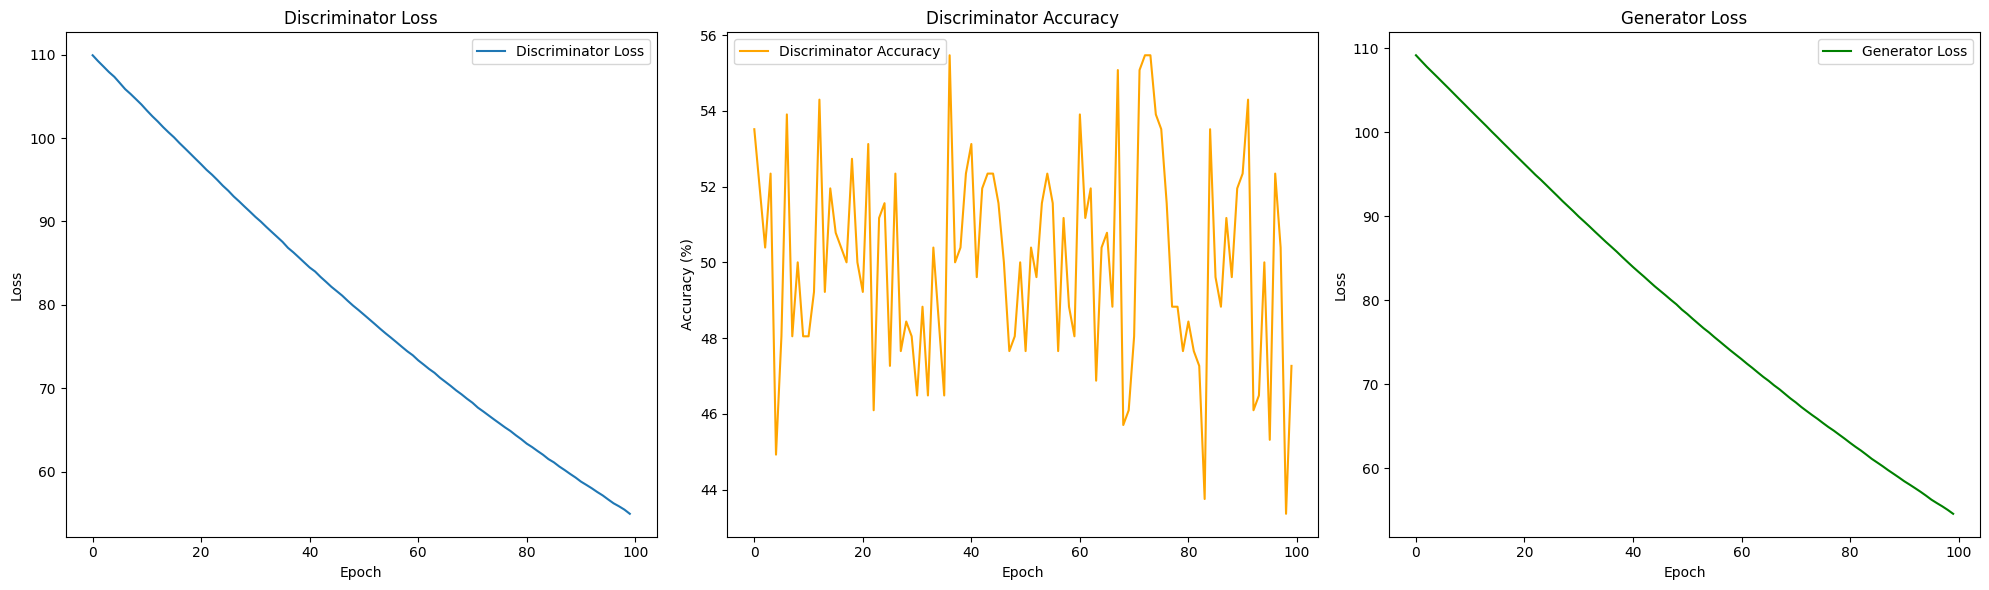

In [9]:
#--------------------------------------------------------------------------------
# Module 7: Visualize the Loss and Accuracy
#--------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Create a new figure for the plots
plt.figure(figsize=(20, 6))

# Plotting Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Discriminator Accuracy
plt.subplot(1, 3, 2)
plt.plot(d_accuracies, label='Discriminator Accuracy', color='orange')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting Generator Loss
plt.subplot(1, 3, 3)
plt.plot(g_losses, label='Generator Loss', color='green')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
#--------------------------------------------------------------------------------
# Module 8: Synthetic Data Generation and Inverse Transformation
# 1. This module defines a function to generate synthetic data samples using a GAN.
# 2. It then inverses the one-hot encoding and normalization transformations to obtain
#    data in a format similar to the original input data. The resulting synthetic data 
#    is then printed for inspection. 
#--------------------------------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Model

# Load the original and encoded data
data = pd.read_csv("Cleaned Data/RT.IRS_Clean_v2.csv")
data_encoded = pd.read_csv("Processed data/data_encoded.csv")

# Define latent dimension used in the generator
latent_dim = 100  # This should match the latent dimension used in your generator

def generate_and_inverse_transform(generator, num_samples=20):
    # Generate synthetic data using the GAN
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    generated_samples = generator.predict(noise)

    # Convert generated samples to DataFrame
    generated_df = pd.DataFrame(generated_samples, columns=data_encoded.columns)

    # Inverse one-hot encoding to get original categorical columns
    categorical_columns = [col for col in data.columns if data[col].dtype == 'object']
    for original_col in categorical_columns:
        one_hot_cols = [col for col in generated_df.columns if col.startswith(original_col + "_")]
        if one_hot_cols:
            # Find the column with the highest value for each row
            max_col = generated_df[one_hot_cols].idxmax(axis=1)
            # Extract the category name and assign it to the original column
            generated_df[original_col] = max_col.apply(lambda x: x.replace(original_col + "_", ""))
            # Drop the one-hot columns
            generated_df.drop(one_hot_cols, axis=1, inplace=True)

    # Inverse normalization to get the original values of numerical columns
    numerical_columns = data_encoded.select_dtypes(include=['float64', 'int64']).columns
    scaler = RobustScaler()
    scaler.fit(data[numerical_columns])  # Fit the scaler to the original data
    generated_df[numerical_columns] = scaler.inverse_transform(generated_df[numerical_columns])

    # Ensure all columns from the original data are present in generated_df
    for col in data.columns:
        if col not in generated_df.columns:
            generated_df[col] = np.nan

    # Ensure the columns are in the same order as the original data
    generated_df = generated_df[data.columns]

    return generated_df

# Call the function and print synthetic data
synthetic_data = generate_and_inverse_transform(generator)


/var/folders/sn/v85b1fvn22v4g_yk95dpk_s80000gn/T/ipykernel_26454/1030822196.py:15: DtypeWarning: Columns (9,40,41,44,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Cleaned Data/RT.IRS_Clean_v2.csv")


1/1 [==============================] - 0s 59ms/step


In [14]:
#--------------------------------------------------------------------------------
# Module 9: Generate Synthesized Data and Save to CSV
#--------------------------------------------------------------------------------

def save_synthesized_data(generator, num_samples=1000, output_file_path="Synthesized Data (GAN)/synthesized_data_GAN.csv"):
    # Generate synthetic data
    synthetic_data = generate_and_inverse_transform(generator, num_samples=num_samples)
    
    # Save the synthesized data to a CSV file
    synthetic_data.to_csv(output_file_path, index=False)

    
    print(f"Synthesized data generated and saved to {output_file_path}")

# Call the function to generate and save the synthetic data
save_synthesized_data(generator)
evaluate_gan_using_ks_test(data, synthetic_data)
evaluate_gan_categorical(data,synthetic_data)

#print("Real data columns:", data.columns)
#print("Generated data columns:", synthetic_data.columns)



32/32 [==============================] - 1s 36ms/step
Synthesized data generated and saved to Synthesized Data (GAN)/synthesized_data_GAN.csv
+-----------------------+----------------+-------------+
|                       |   KS Statistic |     p-value |
|-----------------------+----------------+-------------|
| Upfront Payment       |       1        | 0           |
| Leg 1 Fixed Rate      |       0.570049 | 1.12627e-06 |
| Leg 1 Spread          |       0.999019 | 1.36332e-60 |
| Leg 1 Notional        |       0.573935 | 9.09351e-07 |
| Leg 2 Fixed Rate      |       0.953515 | 4.4396e-27  |
| Leg 2 Spread          |       0.99883  | 4.59582e-59 |
| Leg 2 Notional        |       0.516998 | 1.70821e-05 |
| Option Strike Price   |       1        | 0           |
| Option Currency       |       0        | 1           |
| Option Premium        |       1        | 0           |
| Future Value Notional |       0.985964 | 1.76193e-37 |
+-----------------------+----------------+-------------+
Cat

{'Event':                  Real Frequency  Generated Frequency
 Event                                               
 DSF                    0.011923                  0.0
 Full Netting           0.025582                  0.0
 New Trade              0.908199                  0.0
 Other                  0.006980                  0.0
 Partial Netting        0.020451                  0.0
 nan                    0.000000                  1.0,
 'Execution Timestamp':                      Real Frequency  Generated Frequency
 Execution Timestamp                                     
 2015-06-16 23:59:59        0.006792                  0.0
 2017-04-06 00:00:00        0.003962                  0.0
 2018-05-24 19:45:00        0.005396                  0.0
 2022-09-07 00:00:00        0.003132                  0.0
 2022-11-02 00:00:00        0.003056                  0.0
 nan                        0.000000                  1.0,
 'Dissemination Time':                      Real Frequency  Generated 

In [13]:
#--------------------------------------------------------------------------------
# Module 10: Testing the GAN model
#--------------------------------------------------------------------------------
from scipy.stats import ks_2samp
import numpy as np
import pandas as pd
from tabulate import tabulate

# Numerical columns test
def evaluate_gan_using_ks_test(real_data, generated_data):
    ks_results = {}
    for column in real_data.columns:
        if np.issubdtype(real_data[column].dtype, np.number) and np.issubdtype(generated_data[column].dtype, np.number):
            ks_statistic, p_value = ks_2samp(real_data[column], generated_data[column])
            ks_results[column] = {'KS Statistic': ks_statistic, 'p-value': p_value}
    
    ks_df = pd.DataFrame(ks_results).T
    print(tabulate(ks_df, headers='keys', tablefmt='psql'))
    return ks_df

# Categorical columns test
def evaluate_gan_categorical(real_data, generated_data, top_n=5):
    categorical_results = {}
    for column in real_data.columns:
        if np.issubdtype(real_data[column].dtype, np.number) and np.issubdtype(generated_data[column].dtype, np.number):
            continue

        real_data[column] = real_data[column].astype(str)
        generated_data[column] = generated_data[column].astype(str)

        frequency_real = real_data[column].value_counts(normalize=True).head(top_n)
        frequency_generated = generated_data[column].value_counts(normalize=True).head(top_n)

        comparison = pd.DataFrame({
            'Real Frequency': frequency_real,
            'Generated Frequency': frequency_generated
        }).fillna(0)

        categorical_results[column] = comparison

    for column, df in categorical_results.items():
        print(f"Categorical Data Analysis for Column: {column}")
        print(tabulate(df, headers='keys', tablefmt='psql'))
    
    return categorical_results

# Example usage:
# ks_test_results = evaluate_gan_using_ks_test(real_data, generated_data)
# categorical_test_results = evaluate_gan_categorical(real_data, synthetic_data, top_n=5)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


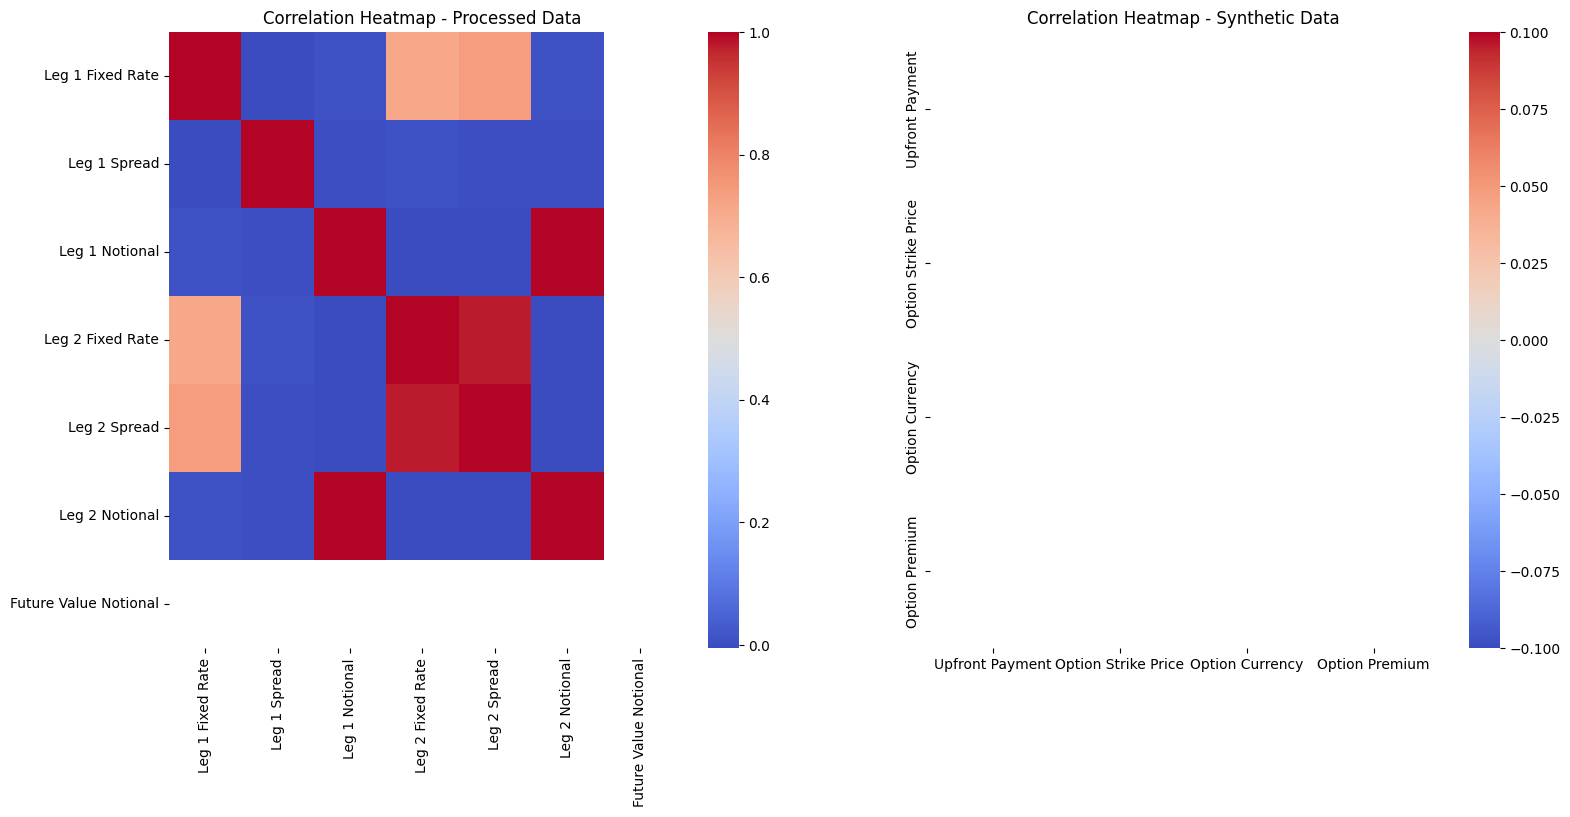

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


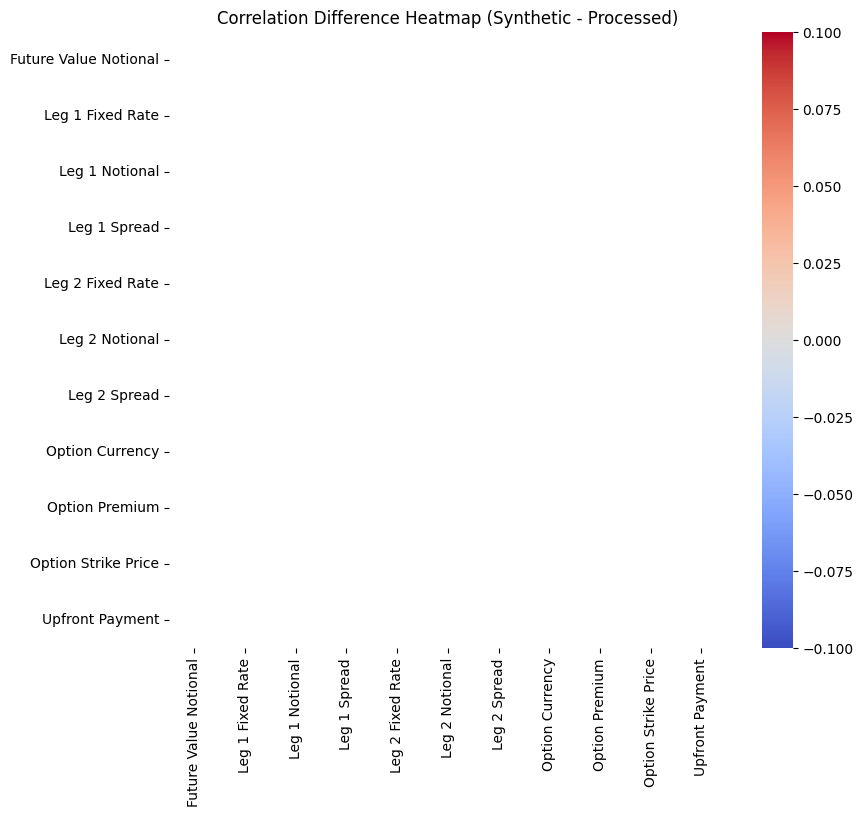

In [17]:
#Module 11 Correlation

# Ensure the 'data_encoded.csv' file is in the correct directory
processed_data = data_encoded
synthetic_data = synthetic_data

import seaborn as sns
import matplotlib.pyplot as plt

# Selecting only numerical columns for correlation analysis
num_cols_processed = processed_data.select_dtypes(include=['float64', 'int64'])
num_cols_synthetic = synthetic_data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrices
corr_matrix_processed = num_cols_processed.corr()
corr_matrix_synthetic = num_cols_synthetic.corr()

# Generating heatmaps
plt.figure(figsize=(18, 8))

# Processed Data Correlation Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(corr_matrix_processed, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap - Processed Data')

# Synthetic Data Correlation Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(corr_matrix_synthetic, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap - Synthetic Data')

plt.show()

# Heatmap of the Differences
corr_diff = corr_matrix_synthetic - corr_matrix_processed

plt.figure(figsize=(9, 8))
sns.heatmap(corr_diff, cmap='coolwarm', annot=False)
plt.title('Correlation Difference Heatmap (Synthetic - Processed)')
plt.show()